In [3]:
import petsc4py
from petsc4py import PETSc

import underworld3 as uw
from underworld3.systems import Stokes
from underworld3 import function

import numpy as np
import sympy
import os
from datetime import datetime
import sys
import matplotlib.pyplot as plt
from underworld3.cython.petsc_discretisation import petsc_dm_find_labeled_points_local

comm = uw.mpi.comm
rank = uw.mpi.rank
size = uw.mpi.size
if size == 1:
    import matplotlib.pyplot as plt

In [4]:
u = uw.scaling.units
ndim = uw.scaling.non_dimensionalise
dim = uw.scaling.dimensionalise

# scaling 3: vel
H = 3000.  * u.kilometer
velocity     = 1e-9 * u.meter / u.second
#g    =   10.0 * u.meter / u.second**2  
#bodyforce    = 3300  * u.kilogram / u.metre**3 * g 
mu           = 1e21  * u.pascal * u.second

KL = H
Kt = KL / velocity
KM = mu * KL * Kt

scaling_coefficients                    = uw.scaling.get_coefficients()
scaling_coefficients["[length]"] = KL
scaling_coefficients["[time]"] = Kt
scaling_coefficients["[mass]"]= KM

In [12]:
D = ndim(3000*u.kilometer)
ratio = 4
wavelength = D/ratio
k = 2.0 * np.pi / wavelength
mu0 = ndim(1e21  * u.pascal * u.second)
g = ndim(10.0 * u.meter / u.second**2 )
rho0 = ndim(4500  * u.kilogram / u.metre**3)
drho = rho0
F0 = ndim(1*u.kilometer)

yres = 80 
xmin, xmax = 0, wavelength
ymin, ymax = -D, 0
boxl = xmax-xmin
boxh = ymax-ymin
xres = int(boxl/boxh*yres)

x0 = np.linspace(xmin,xmax,xres+1)
y0 = F0*np.cos(k*x0)

def perturbation(x):
    return F0 * np.cos(k*x)

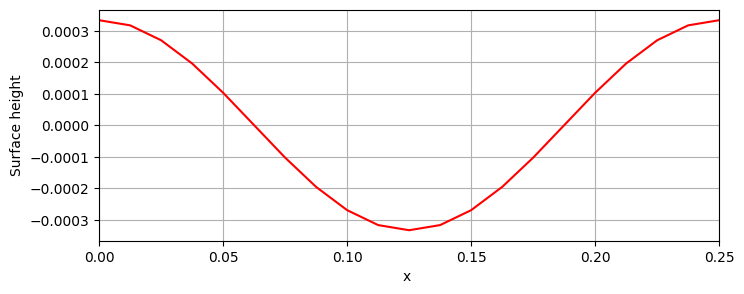

In [6]:
# fname = f'The surface of initial step'
# fname_save = fname +".png"
# fig,ax1 = plt.subplots(1, 1, figsize=(8,3))
# ax1.set(xlabel='x ', ylabel='Surface height') 
# ax1.plot(x0,y0,c='r',label="")
# ax1.set_xlim([xmin,xmax])
# ax1.grid()
# plt.savefig(fname_save,dpi=150,bbox_inches='tight')

In [13]:
tau0 = 2*k*mu0/drho/g
# print(dim(tau0,u.kiloyear))
# print((ratio*4*np.pi*1e21/4500/3e6/10)/(365.25*24*60*60*1000))  #kiloyear

tmax = tau0*4

z = 0
x = x0

tau = (D*k+np.sinh(D*k)*np.cosh(D*k))/(np.sinh(D*k)**2)*tau0
A = -F0/k/tau0
B = -F0/k/tau
C = F0/tau
E = F0/tau/np.tanh(D*k)
phi = np.sin(k*x)*np.exp(-tmax/tau)*(A*np.sinh(k*z)+B*np.cosh(k*z)+C*z*np.sinh(k*z)+E*z*np.cosh(k*z))
F = F0*np.exp(-tmax/tau)
y = F*np.cos(k*x)

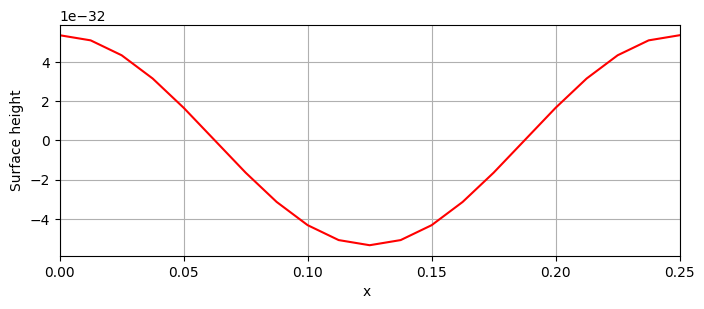

In [15]:
# fname = f'The surface of final step'
# fname_save = fname +".png"
# fig,ax1 = plt.subplots(1, 1, figsize=(8,3))
# ax1.set(xlabel='x ', ylabel='Surface height') 
# ax1.plot(x0,y0,c='k',label="initial surface")
# ax1.plot(x,y,c='r',label="")
# ax1.set_xlim([xmin,xmax])
# ax1.grid()
# plt.savefig(fname_save,dpi=150,bbox_inches='tight')

In [11]:
case_bc = "freesurf"

timeratio = (1/4)**int(sys.argv[1])

render = True
dt_set    = tau0*timeratio
max_time  = tmax + dt_set
save_every = int(tau0/dt_set)
if save_every < 1:
    save_every = int(1)

use_fssa = False

outputPath = "op_2DRelaxation_FreeSurf" + "_yres{:n}_dt{:.1f}ka_Tmax{:.1f}ka/".format(yres,dim(dt_set,u.kiloyear).m,dim(max_time,u.kiloyear).m)
if uw.mpi.rank == 0:
    # delete previous model run
    if os.path.exists(outputPath):
        for i in os.listdir(outputPath):
            os.remove(outputPath+ i)
            
    ### create folder if not run before
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)

#print(ndim(max_time),ndim(dt_set),ndim(bodyforce))
print(outputPath)

TypeError: can't multiply sequence by non-int of type 'float'

In [ ]:
def plot_mesh(title,mesh,showFig=True):
    import numpy as np
    import pyvista as pv
    import vtk
    
    pv.global_theme.background = "white"
    pv.global_theme.window_size = [500, 500]
    pv.global_theme.jupyter_backend = "static"
    pv.global_theme.smooth_shading = True
    pv.global_theme.show_edges = True
    pv.global_theme.axes.show = True

    mesh.vtk("tmp_box_mesh.vtk")
    pvmesh = pv.read("tmp_box_mesh.vtk")
    pl = pv.Plotter()
    pl.add_mesh(pvmesh,'Black', 'wireframe')

    pl.add_title(title,font_size=11)
    if showFig:
        pl.show(cpos="xy")
    
    pl.screenshot(outputPath+title+".png",window_size=pv.global_theme.window_size,return_img=False) 
    pvmesh.clear_data() 
    pvmesh.clear_point_data()


def plot_meshswarm(title,mesh,swarm,material,showSwarm=False,showFig=True):
    import numpy as np
    import pyvista as pv
    import vtk
    
    pv.global_theme.background = "white"
    pv.global_theme.window_size = [500, 500]
    pv.global_theme.jupyter_backend = "static"
    pv.global_theme.smooth_shading = True
    pv.global_theme.show_edges = True
    pv.global_theme.axes.show = True

    mesh.vtk("tmp_box_mesh.vtk")
    pvmesh = pv.read("tmp_box_mesh.vtk")
    pl = pv.Plotter()
    pl.add_mesh(pvmesh,'Black', 'wireframe')

    if showSwarm:
        with swarm.access():
            points = np.zeros((swarm.data.shape[0],3))
            points[:,0] = swarm.data[:,0]
            points[:,1] = swarm.data[:,1]
        point_cloud = pv.PolyData(points)
        with swarm.access():
            point_cloud.point_data["M"] = material.data.copy()
        #pl.add_points(point_cloud, color="red",render_points_as_spheres=False, point_size=3, opacity=0.5)
        pl.add_mesh(point_cloud, cmap="coolwarm", edge_color="Black", show_edges=False, scalars='M',
                        use_transparency=False, opacity=0.95, point_size= 3)
    pl.add_title(title,font_size=11)
    if showFig:
        pl.show(cpos="xy")
    
    pl.screenshot(outputPath+title+".png",window_size=pv.global_theme.window_size,return_img=False) 
    pvmesh.clear_data()
    pvmesh.clear_point_data()
    
def plot_meshswarmvel(title,mesh,swarm,material,vel,skip=2,mag=4,showSwarm=True,showFig=True):
    import numpy as np
    import pyvista as pv
    import vtk
    
    pv.global_theme.background = "white"
    pv.global_theme.window_size = [500, 500]
    pv.global_theme.jupyter_backend = "static"
    pv.global_theme.smooth_shading = True
    pv.global_theme.show_edges = True
    pv.global_theme.axes.show = True

    mesh.vtk("tmp_box_mesh.vtk")
    pvmesh = pv.read("tmp_box_mesh.vtk")
    pl = pv.Plotter()
    pl.add_mesh(pvmesh,'Black', 'wireframe')

    if showSwarm:
        with swarm.access():
            points = np.zeros((swarm.data.shape[0],3))
            points[:,0] = swarm.data[:,0]
            points[:,1] = swarm.data[:,1]
        point_cloud = pv.PolyData(points)
        with swarm.access():
            point_cloud.point_data["M"] = material.data.copy()
        #pl.add_points(point_cloud, color="red",render_points_as_spheres=False, point_size=3, opacity=0.5)
        pl.add_mesh(point_cloud, cmap="coolwarm", edge_color="Black", show_edges=False, scalars='M',
                        use_transparency=False, opacity=0.95, point_size= 3)
        pl.remove_scalar_bar("M")
        
    v_vectors = np.zeros((mesh.data[::skip].shape[0], 3))
    v_vectors[:, 0] = uw.function.evalf(vel.sym[0], mesh.data[::skip], mesh.N)
    v_vectors[:, 1] = uw.function.evalf(vel.sym[1], mesh.data[::skip], mesh.N)
    v_max = v_vectors.max()
    v_vectors = v_vectors/v_max
    
    v_points = np.zeros((mesh.data[::skip].shape[0], 3))
    v_points[:,0] = mesh.data[::skip][:,0]
    v_points[:,1] = mesh.data[::skip][:,1]
    arrows = pl.add_arrows(v_points,v_vectors, color="black",mag=mag,opacity=1.0, show_scalar_bar=False)
    
    
    pl.add_title(title,font_size=11)
    if showFig:
        pl.show(cpos="xy")
    
    pl.screenshot(outputPath+title+".png",window_size=pv.global_theme.window_size,return_img=False) 
    pvmesh.clear_data()
    pvmesh.clear_point_data()

In [ ]:
from underworld3.utilities._api_tools import uw_object
from scipy.spatial import distance
class PopulationControl_DeformMesh(uw_object):
    def __init__(self, swarm):
        self._swarm = swarm
        with swarm.access():
            self._swarm_coords     = np.copy(np.ascontiguousarray( self._swarm.data))
            self._swarm_cellid     = np.copy(np.ascontiguousarray( self._swarm.particle_cellid.data[:,0]))
            self._particleNumber   = self._swarm.data.shape[0]
            self._mesh_cID, self._cIDcount  = np.unique(self._swarm_cellid, return_counts=True)
            self._swarm_ppc = self._cIDcount[0]

    def repopulate(self,mesh,updateField=None):
    # similar method as PopulationControl.redisturibute, 
    # but update the owning cell frist, using new swarm build on the deformed mesh to add particles, 
    # and delete the over_populated particles 
        self._updateField = updateField
        self._mesh = mesh
        
        # update the owning cell
        cellid = self._swarm.dm.getField("DMSwarm_cellid")
        coords = self._swarm.dm.getField("DMSwarmPIC_coor").reshape((-1, swarm.dim))
        cellid[:] = self._swarm.mesh.get_closest_cells(coords).reshape(-1)
        self._swarm.dm.restoreField("DMSwarmPIC_coor")
        self._swarm.dm.restoreField("DMSwarm_cellid")
        self._swarm.dm.migrate(remove_sent_points=True)
        self._swarm._index = None
        self._swarm._nnmapdict = {}

        self._updateField = updateField

        ### get the particle positions in the cell from the deformed mesh
        _newswarm = uw.swarm.Swarm(self._mesh)
        _newswarm.populate_petsc(fill_param=fill_parameter,layout=uw.swarm.SwarmPICLayout.GAUSS)
        with _newswarm.access():
            original_swarm_coords = np.copy(np.ascontiguousarray(_newswarm.data))

        ### get the current swarm positions in the cell
        with self._swarm.access():
            current_swarm_coords = self._swarm.data
            current_swarm_cells = self._swarm.particle_cellid.data[:,0]

        current_particle_cellID, current_ppc  = np.unique(current_swarm_cells, return_counts=True)

        ### find cells that are empty
        empty_cells = self._mesh_cID[np.isin(self._mesh_cID, current_particle_cellID, invert=True)]
        empty_cell_coords = original_swarm_coords[np.isin(self._swarm_cellid,  empty_cells)]

        ### find under-populated cells
        underpopulated_cells = current_particle_cellID[current_ppc < self._swarm_ppc]
        ### number of particles missing from each cell
        underpopulated_cell_coords = []

        for cell in underpopulated_cells:
            ### get the current number of particles in the cell
            current_particles = current_ppc[current_particle_cellID == cell][0]
            ### get the number of particles to add
            no_particles_to_add = self._swarm_ppc - current_particles

            original_cell_coords = original_swarm_coords[self._swarm_cellid == cell]
            current_cell_coords  = current_swarm_coords[current_swarm_cells == cell]

            ### caculate the distances between the original and current particle positions
            point_distance = distance.cdist(original_cell_coords, current_cell_coords, 'euclidean')
            ### add the ones with the largest distance
            underpopulated_cell_coords.append(original_cell_coords[np.min(point_distance, axis=1).argsort()[::-1]][:no_particles_to_add])
 

        if underpopulated_cell_coords:  # Check if the list is not empty
            underpopulated_cell_coords = np.concatenate(underpopulated_cell_coords)
        else:
            underpopulated_cell_coords = np.empty(shape=(0,2))  # Create an empty numpy array

        ### Combination of the empty cells and the underpopulated cells
        particles_to_add = np.vstack([underpopulated_cell_coords, empty_cell_coords])

        uw.mpi.barrier()
        new_cells = self._swarm.mesh.get_closest_local_cells(particles_to_add)
        
        if isinstance(new_cells, int):
            new_cells = np.array([new_cells])

        # Ensure that 'valid' has the same length as 'particles_to_add'
        if len(particles_to_add) != len(new_cells):
            new_cells = np.resize(new_cells, len(particles_to_add))

        valid = new_cells != -1

        valid_coords = particles_to_add[valid]
        valid_cells = new_cells[valid]

        all_local_coords = np.vstack([current_swarm_coords, valid_coords])

        all_local_cells = np.hstack([current_swarm_cells, valid_cells])

        ### do interp before adding particles, otherwise interp happens from the newly added particles
        if (self._updateField != None):
            ### defualt to the nnn value
            new_particle_mat = np.rint( self._updateField.rbf_interpolate(all_local_coords) )#, nnn=self._swarm_ppc))
        
        swarm_new_size = all_local_coords.data.shape[0]

        self._swarm.dm.addNPoints(swarm_new_size - current_swarm_coords.shape[0])

        cellid = self._swarm.dm.getField("DMSwarm_cellid")
        coords = self._swarm.dm.getField("DMSwarmPIC_coor").reshape((-1, self._swarm.dim))

        coords[...] = all_local_coords[...]
        cellid[:]   = all_local_cells[:]

        self._swarm.dm.restoreField("DMSwarmPIC_coor")
        self._swarm.dm.restoreField("DMSwarm_cellid")

        if (self._updateField != None):
            with self._swarm.access(self._updateField):
                self._updateField.data[:,0] = new_particle_mat[:,0]

        uw.mpi.barrier()
        
        ### get the current swarm positions in the cell
        with self._swarm.access():
            current_swarm_coords = self._swarm.data
            current_swarm_cells = self._swarm.particle_cellid.data[:,0]

        current_particle_cellID, current_ppc  = np.unique(current_swarm_cells, return_counts=True)

        ### find over-populated cells
        overpopulated_cells = current_particle_cellID[current_ppc > self._swarm_ppc]

        overpopulated_cell_coords = []

        for cell in overpopulated_cells:
            ### get the current particles in the cell
            current_particles = current_ppc[current_particle_cellID == cell][0]
            ### number of particles to delete
            no_particles_to_remove = current_particles - self._swarm_ppc
            ### randomly select particles to remove from the current cell
            #rng = np.random.default_rng()
    
            #### Selection of coords doesn't delete all particles (?)
            current_cell_coords  = current_swarm_coords[current_swarm_cells == cell]
            current_cell_coords_local = self._swarm.mesh._centroids[cell].reshape(1,-1)
            point_distance = distance.cdist(current_cell_coords,current_cell_coords_local, 'euclidean')
    
            np.min(point_distance, axis=1).argsort()[::-1][:int(no_particles_to_remove)]
            overpopulated_cell_coords.append(current_cell_coords[np.min(point_distance, axis=1).argsort()[::-1][:int(no_particles_to_remove)]])

        if overpopulated_cell_coords:  # Check if the list is not empty
            particles_to_remove = np.concatenate(overpopulated_cell_coords)
        else:
            particles_to_remove = np.empty(shape=(0,2))  # Create an empty numpy array

        # Check if all_current_coords and particles_to_remove are not empty
        with self._swarm.access(self._swarm.particle_coordinates):
            ### get current coords
            all_current_coords = self._swarm.data

            if particles_to_remove.size > 0:
                ### get number of particles to remove
                no_particles_to_remove = particles_to_remove.shape[0]

                    
                # Calculate point_distance
                point_distance = distance.cdist(all_current_coords, particles_to_remove, 'euclidean')

                # Get the index of particles to remove
                index_condition = np.min(point_distance, axis=1).argsort()[:no_particles_to_remove]

                # Set coords to 1.0e100 so they are deleted by the DM, following the same logic as the remeshing example
                self._swarm.data[index_condition] = 1.0e100

        return

In [ ]:
mesh = uw.meshing.StructuredQuadBox(elementRes=(int(xres), int(yres)), minCoords=(xmin, ymin), maxCoords=(xmax, ymax))
init_mesh = uw.meshing.StructuredQuadBox(elementRes=(int(xres), int(yres)), minCoords=(xmin, ymin), maxCoords=(xmax, ymax))

botwall = petsc_dm_find_labeled_points_local(mesh.dm,"Bottom")
topwall = petsc_dm_find_labeled_points_local(mesh.dm,"Top")

# # dq2dq1
# v = uw.discretisation.MeshVariable("V", mesh, mesh.dim, degree=2)
# p = uw.discretisation.MeshVariable("P", mesh, 1, degree=1)

# q1dq0
v = uw.discretisation.MeshVariable("V", mesh, mesh.dim, degree=1,continuous=True)
p = uw.discretisation.MeshVariable("P", mesh, 1, degree=0,continuous=False)

timeField     = uw.discretisation.MeshVariable("time", mesh, 1, degree=1)

swarm  = uw.swarm.Swarm(mesh)
material  = uw.swarm.IndexSwarmVariable("M", swarm, indices=1, proxy_degree=1)  
fill_parameter= 1 # swarm fill parameter
swarm.populate_petsc(fill_param=fill_parameter,layout=uw.swarm.SwarmPICLayout.GAUSS)

In [ ]:
densityM = rho0
viscM = mu0
ND_gravity = ndim(g)

MIndex = 0
with swarm.access(material):
    material.data[:] = MIndex

density_fn = material.createMask([densityM])
visc_fn = material.createMask([viscM])

Tmesh = uw.discretisation.MeshVariable("Tmesh", init_mesh, 1, degree=1)
Bmesh = uw.discretisation.MeshVariable("Bmesh", init_mesh, 1, degree=1)

mesh_solver = uw.systems.Poisson(init_mesh, u_Field=Tmesh, solver_name="FreeSurf_solver")
mesh_solver.constitutive_model = uw.constitutive_models.DiffusionModel
mesh_solver.constitutive_model.Parameters.diffusivity = 1. 
mesh_solver.f = 0.0
mesh_solver.add_dirichlet_bc(Bmesh.sym[0], "Top",0)
mesh_solver.add_dirichlet_bc(Bmesh.sym[0], "Bottom",0)

x = init_mesh.data[topwall,0]
with init_mesh.access(Bmesh):
    Bmesh.data[topwall, 0] = perturbation(x)
    Bmesh.data[botwall, 0] = init_mesh.data[botwall,-1]
mesh_solver.solve()

def update_mesh():
    with init_mesh.access():
        new_mesh_coords = init_mesh.data
        new_mesh_coords[:,-1] = Tmesh.data[:,0]
    return new_mesh_coords
new_mesh_coords = update_mesh()
mesh.deform_mesh(new_mesh_coords)

In [ ]:
stokes = uw.systems.Stokes(mesh, velocityField=v, pressureField=p)
stokes.constitutive_model = uw.constitutive_models.ViscousFlowModel
stokes.bodyforce = sympy.Matrix([0, -1 * ND_gravity * density_fn])
stokes.constitutive_model.Parameters.shear_viscosity_0 = visc_fn
stokes.saddle_preconditioner = 1.0 / stokes.constitutive_model.Parameters.shear_viscosity_0
stokes.add_dirichlet_bc((0.0,0.0), "Left", (0,))
stokes.add_dirichlet_bc((0.0,0.0), "Right", (0,))
stokes.add_dirichlet_bc((0.0,0.0), "Bottom", (0,1))

if uw.mpi.size == 1:
    stokes.petsc_options['pc_type'] = 'lu'

stokes.tolerance = 1.0e-6
stokes.petsc_options["ksp_rtol"] = 1.0e-6
stokes.petsc_options["ksp_atol"] = 1.0e-6
stokes.petsc_options["snes_converged_reason"] = None
stokes.petsc_options["snes_monitor_short"] = None

In [ ]:
if use_fssa:
    theta = 0.5*densityM*ND_gravity*dt_set
    FSSA_traction = theta*mesh.Gamma.dot(v.sym) * mesh.Gamma
    stokes.add_natural_bc(FSSA_traction, "Top")

In [ ]:
pop_control = PopulationControl_DeformMesh(swarm)

In [ ]:
def _adjust_time_units(val):
    """ Adjust the units used depending on the value """
    if isinstance(val, u.Quantity):
        mag = val.to(u.years).magnitude
    else:
        val = dim(val, u.years)
        mag = val.magnitude
    exponent = int("{0:.3E}".format(mag).split("E")[-1])

    if exponent >= 9:
        units = u.gigayear
    elif exponent >= 6:
        units = u.megayear
    elif exponent >= 3:
        units = u.kiloyears
    elif exponent >= 0:
        units = u.years
    elif exponent > -3:
        units = u.days
    elif exponent > -5:
        units = u.hours
    elif exponent > -7:
        units = u.minutes
    else:
        units = u.seconds
    return val.to(units)

In [ ]:
from scipy.interpolate import interp1d
from scipy.interpolate import CloughTocher2DInterpolator

class FreeSurfaceProcessor(object): 
    def __init__(self,v,dt):
        """
        Parameters
        ----------
        _init_mesh : the original mesh
        mesh : the updating model mesh
        vel : the velocity field of the model
        dt : dt for advecting the surface
        """
        if mesh.dim == 2:
            self.init_mesh = uw.meshing.StructuredQuadBox(elementRes=(int(xres), int(yres)), minCoords=(xmin, ymin), maxCoords=(xmax, ymax))
        else:
            self.init_mesh = uw.meshing.StructuredQuadBox(elementRes=(int(xres), int(yres),int(zres)), minCoords=(xmin, ymin, zmin), maxCoords=(xmax, ymax, zmax))
        self.Tmesh = uw.discretisation.MeshVariable("Tmesh", self.init_mesh, 1, degree=1)
        self.Bmesh = uw.discretisation.MeshVariable("Bmesh", self.init_mesh, 1, degree=1)
        self.mesh_solver = uw.systems.Poisson(self.init_mesh , u_Field=self.Tmesh, solver_name="FreeSurf_solver")
        self.mesh_solver.constitutive_model = uw.constitutive_models.DiffusionModel
        self.mesh_solver.constitutive_model.Parameters.diffusivity = 1. 
        self.mesh_solver.f = 0.0
        self.mesh_solver.add_dirichlet_bc(self.Bmesh.sym[0], "Top",0)
        self.mesh_solver.add_dirichlet_bc(self.Bmesh.sym[0], "Bottom",0)

        self.v = v
        self._dt   = dt
        self.top = topwall
        self.bottom = botwall

    def _solve_sle(self):
        self.mesh_solver.solve()
     
    def _advect_surface(self):
        if self.top.size > 0:
            if mesh.dim == 2:
                coords = mesh.data[self.top]
                x = coords[:,0]
                y = coords[:,-1]
                vx = uw.function.evalf(self.v.sym[0], coords)
                vy = uw.function.evalf(self.v.sym[1], coords)
                
                # Advect top surface
                x2 = x + vx * self._dt
                y2 = y + vy * self._dt
        
                # Spline top surface
                f = interp1d(x2, y2, kind='cubic', fill_value='extrapolate')
    
                with self.init_mesh.access(self.Bmesh):
                    self.Bmesh.data[self.bottom, 0] = mesh.data[self.bottom, -1]
                    self.Bmesh.data[self.top, 0] = f(x)      
            else:
                coords = mesh.data[self.top]
                x = coords[:,0]
                y = coords[:,1]
                z = coords[:,-1]
                vx = uw.function.evalf(self.v.sym[0], coords)
                vy = uw.function.evalf(self.v.sym[1], coords)
                vz = uw.function.evalf(self.v.sym[2], coords)
                
                # Advect top surface
                x2 = x + vx * self._dt
                y2 = y + vy * self._dt
                z2 = z + vz * self._dt
        
                # Spline top surface
                f = CloughTocher2DInterpolator((x2, y2), z2)
    
                with self.init_mesh.access(self.Bmesh):
                    self.Bmesh.data[self.bottom, 0] = mesh.data[self.bottom, -1]
                    self.Bmesh.data[self.top, 0] = f((x,y)) 
        uw.mpi.barrier()
        #self.Bmesh.syncronise()
         
    def _update_mesh(self):
        with self.init_mesh.access():
            new_mesh_coords = self.init_mesh.data
            new_mesh_coords[:,-1] = self.Tmesh.data[:,0]   
        #mesh.deform_mesh(new_mesh_coords)
        return new_mesh_coords
        
    
    def solve(self):
        self._advect_surface()
        self._solve_sle()
        new_mesh_coords = self._update_mesh()
        return new_mesh_coords

In [ ]:
step      = 0
max_steps = 2
time      = 0
dt        = 0

# if rank == 0:
#     fw = open(outputPath + "ParticlePosition.txt","w")
#     fw.write("Time \t W \t dWdT \n")
#     fw.close()
# uw.mpi.barrier()
w = []
dwdt = []
times = []

while time < max_time:
#while step < max_steps:
    
    if uw.mpi.rank == 0:
        string = """Step: {0:5d} Model Time: {1:6.1f} dt: {2:6.1f} ({3})\n""".format(
        step, _adjust_time_units(time),
        _adjust_time_units(dt),
        datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
        sys.stdout.write(string)
        sys.stdout.flush()
    
    #stokes = build_stokes_solver(mesh,v,p)
    stokes.solve(zero_init_guess=False,_force_setup=True)

    if step%save_every ==0:
        if uw.mpi.rank == 0:
            print(f'\nSave data:')
        with mesh.access(timeField):
            timeField.data[:,0] = dim(time, u.megayear).m

        mesh.petsc_save_checkpoint(meshVars=[v, p, timeField], index=step, outputPath=outputPath)
        #swarm.petsc_save_checkpoint(swarmName='swarm', index=step, outputPath=outputPath) 
        #interfaceSwarm.petsc_save_checkpoint(swarmName='interfaceSwarm', index=step, outputPath=outputPath) 
        

    times.append(time)
    dt_solver = stokes.estimate_dt()
    dt = min(dt_solver,dt_set)
    
    swarm.advection(V_fn=stokes.u.sym, delta_t=dt)
    #interfaceSwarm.advection(V_fn=stokes.u.sym, delta_t=dt)

    freesuface = FreeSurfaceProcessor(v,dt)
    new_mesh_coords=freesuface.solve()
    mesh.deform_mesh(new_mesh_coords)
    if uw.mpi.rank == 0:
        print(f'\nrepopulate start:')
    pop_control.repopulate(mesh,material)
    if uw.mpi.rank == 0:
        print(f'\nrepopulate end:')
    #repopulate(swarm,mesh,updateField=material)
    #pop_control.redistribute(material)
    #pop_control.repopulate(material)

    step += 1
    time += dt

In [ ]:
#plot_meshswarmvel(f'vel_step{str(step)}',mesh,swarm,material,v,skip=2,mag=0.8,showSwarm=True,showFig=True)